In [2]:
#importing required libraries
import os
#import pydicom
import numpy as np
import nibabel as nib
import glob
from PIL import Image
#from imread import imread, imsave
#import mahotas
import nilearn
from nilearn import image
from nilearn.image import resample_img
import SimpleITK as sitk
import scipy
from scipy import interpolate
import torch
import matplotlib.pyplot as plt
from nilearn.plotting import show

In [3]:
#read required files and check for their shape
path = glob.glob('selected/*')
file_names = []
file_data = []
file_info = []
file_header = []
data_shapes = []
for images in path:
    file_names.append(images)
    data_load = nib.load(images)
    file_data.append(data_load)
    info = data_load.get_data()
    file_info.append(info)
    header = data_load.header
    file_header.append(header)

C:\Users\feuer\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':
C:\Users\feuer\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':
C:\Users\feuer\anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_d

In [4]:
#get voxel data and pixel data
vox_data = []
data_shapes = []
for headers in file_header:
    a = headers.get_zooms()
    vox_data.append(a)
for shapes in file_data:
    pix_shape = shapes.shape
    data_shapes.append(pix_shape) 
print(vox_data[1])
print(len(data_shapes),len(vox_data))

(0.9375, 0.9375, 1.25)
22 22


In [5]:
#processing for isotropic voxels
target_resolution = []
for (x_p,y_p,z_p),(x_v,y_v,z_v) in zip(data_shapes,vox_data):
    required_pixel_resolution = ((x_p*x_v)/z_v,(y_p*y_v)/z_v,(z_p*z_v)/z_v)
    required_pixel_resolution = (int(required_pixel_resolution[0]),int(required_pixel_resolution[1]),int(required_pixel_resolution[2]))
    print(required_pixel_resolution)
    target_resolution.append(required_pixel_resolution) 

(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)
(192, 192, 130)


In [6]:
# making data to isotropic voxels
required_resolution = []
required_new_resolution_data = []
#target_affine = np.eye(4)
for resolution,file,y in zip(target_resolution,file_names,file_data):
    new_resolution = resample_img(file, target_affine=y.affine, target_shape=resolution)
    new_resolution_data = new_resolution.get_data()
    new_resolution_data = np.asarray(new_resolution_data)
    required_new_resolution_data.append(new_resolution_data)
    required_resolution.append(new_resolution)
print(required_resolution[1].shape)

C:\Users\feuer\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
C:\Users\feuer\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  import sys
C:\Users\feuer\anaconda3\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forw

(192, 192, 130)


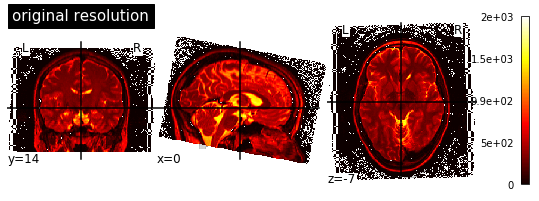

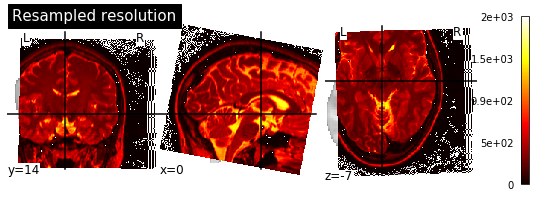

In [7]:
#plotting original data and resampled data
from nilearn import plotting

plotting.plot_stat_map(file_data[5],
                       title="original resolution")
plotting.plot_stat_map(required_resolution[5],cut_coords=(0, 14, -7),
                       title="Resampled resolution")
plotting.show()

In [8]:
# checking shapes of resampled data
required_new_resolution_array_data= np.asarray(required_new_resolution_data)
print(required_new_resolution_array_data.shape)
print(required_new_resolution_array_data[1].shape)

(22, 192, 192, 130)
(192, 192, 130)


In [9]:
#downsampling resampled data by removing alternative slices
gts = []
x = np.arange(1,131,2)
r,_,_,_ = required_new_resolution_array_data.shape
for i in range(r):
    test = required_new_resolution_array_data[i,:,:,:]
    lbs = []
    for i in x:
        slices = test[:,:,i]
        lbs.append(slices)    
    lbs = np.asarray(lbs)
    lbs = np.moveaxis(lbs,0,-1)
    gts.append(lbs)
print(gts[1].shape)
print(type(gts[1]))
print(required_resolution[1].shape)

(192, 192, 65)
<class 'numpy.ndarray'>
(192, 192, 130)


In [10]:
#converting 3d to 5d
print(gts[1].shape)
required_arr_4d = []
required_arr_5d = []
for i in gts:
    #swapped = np.moveaxis(i, 2, 0)  
    arr4d = np.expand_dims(i, 0)
    arr5d = np.expand_dims(arr4d,0)
    #arr5d = np.moveaxis(arr5d,4,2)
    required_arr_4d.append(arr4d)
    required_arr_5d.append(arr5d)
print(required_arr_4d[1].shape)
print(required_arr_5d[1].shape)

(192, 192, 65)
(1, 192, 192, 65)
(1, 1, 192, 192, 65)


In [11]:
#getting torch tensors from numpy array
tor_5d_arr = []
for x in required_arr_5d:
    tor_data = torch.from_numpy(x)
    tor_5d_arr.append(tor_data)
print(tor_5d_arr[1].shape)  

torch.Size([1, 1, 192, 192, 65])


In [12]:
#Interpolation of downsampled data for adding noise
needed = tor_5d_arr[1]
tor_inter = torch.nn.functional.interpolate(needed, size=(192,192,130), scale_factor=None, mode='trilinear', align_corners=None)
print(tor_inter.shape)

torch.Size([1, 1, 192, 192, 130])


C:\Users\feuer\anaconda3\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [13]:
#Getting numpy array from pytorch tensors 
pt2np = tor_inter.numpy()
pt2np.shape

(1, 1, 192, 192, 130)

In [14]:
#Verifying noise from interpolated image
print(pt2np.mean())
print(required_new_resolution_array_data[1].mean())

191.43582805334344
192.03593772387967


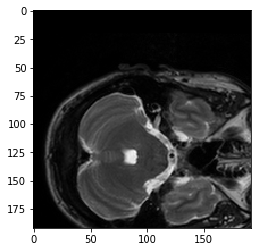

In [15]:
#Squeezing 5d to 3d for plotting
sqez1 = np.squeeze(pt2np, axis=0)
sqez2 = np.squeeze(sqez1,axis = 0)
plt.imshow(sqez2[:,:,39], cmap='gray')

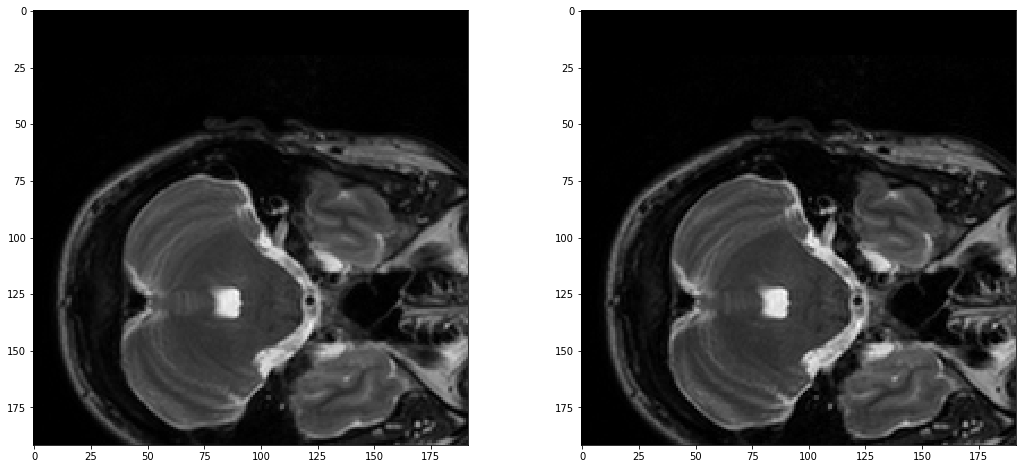

In [16]:
#checking for the noise in the image slice with isotropic file
fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(sqez2[:,:,39], cmap= "gray")
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(required_new_resolution_array_data[1][:,:,39],cmap= "gray")

In [17]:
req_swap = np.moveaxis(required_new_resolution_array_data[1],2,0)

In [18]:
#3d volume verification of isotropic volume and interpolated volume
swapped = np.moveaxis(sqez2,2,0)
print(swapped.shape)
plt_sqeez = sitk.GetImageFromArray(swapped)
req_plt_sqeez = sitk.GetImageFromArray(req_swap)
sitk.Show(plt_sqeez)
sitk.Show(req_plt_sqeez)

(130, 192, 192)


In [19]:
import torch
import torch.nn as nn

In [20]:
def create_conv_bn_relu(in_channels, out_channels, kernel_size=3, padding=1):
    return nn.Sequential(
        nn.Conv3d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm3d(out_channels),
        nn.ReLU(inplace=True),
    )

In [21]:
def create_double_conv(in_channels, mid_channels, out_channels, kernel_size=3, padding=1):
    return nn.Sequential(
        create_conv_bn_relu(in_channels, mid_channels, kernel_size, padding),
        create_conv_bn_relu(mid_channels, out_channels, kernel_size, padding),
    )

In [22]:
def upsample(x1, x2):

    # here you can also use ConvTranspose2d. There are some drawbacks to that.
    # ConvTranspose2d (aka. Deconvolution) creats checkerboard pattern. You can
    # fix that with more convolution layers after ConvTranspose2d
    # more about it -> https://distill.pub/2016/deconv-checkerboard/
    # In my experience basic bilinear upsample is faster and it dosen't require
    # more conv layers after upsample

    return torch.nn.functional.interpolate(
        x1,
        size=(x2.size()[2], x2.size()[3], x2.size()[4]),
        scale_factor=None,
        mode='trilinear',
        align_corners=True
    )

In [23]:
class UNet(nn.Module):
    def __init__(self, n_channels, output_channels):
        super(UNet, self).__init__()

        self.n_channels = n_channels
        self.output_channels = output_channels

        self.double_conv_down_0 = create_double_conv(1, 10, 10)
        self.double_conv_down_1 = create_double_conv(10, 10, 10)
        self.double_conv_down_2 = create_double_conv(10, 10, 10)
        self.double_conv_down_3 = create_double_conv(10, 10, 10)
        self.double_conv_down_4 = create_double_conv(10, 10, 10)

        self.maxpool_1 = nn.MaxPool3d((1, 2, 2))
        self.maxpool_2 = nn.MaxPool3d((1, 2, 2))
        self.maxpool_3 = nn.MaxPool3d((1, 2, 2))
        self.maxpool_4 = nn.MaxPool3d((1, 2, 2))

        self.double_conv_up_1 = create_double_conv(20, 10, 10)
        self.double_conv_up_2 = create_double_conv(20, 10, 10)
        self.double_conv_up_3 = create_double_conv(20, 10, 10)
        self.double_conv_up_4 = create_double_conv(20, 10, 10)

        self.output_conv = nn.Conv3d(10, 1, kernel_size=1)

    def forward(self, x):
        # x is in BCDHW format

        x1 = self.double_conv_down_0(x)
        x = self.maxpool_1(x1)
        x2 = self.double_conv_down_1(x)
        x = self.maxpool_2(x2)
        x3 = self.double_conv_down_2(x)
        x = self.maxpool_3(x3)
        x4 = self.double_conv_down_3(x)
        #x = self.maxpool_4(x4)
        #x5 = self.double_conv_down_4(x)

        x = upsample(x4, x3)
        x = torch.cat([x, x3], dim=1)
        x = self.double_conv_up_1(x)

        x = upsample(x, x3)
        x = torch.cat([x, x3], dim=1)
        x = self.double_conv_up_2(x)

        x = upsample(x, x2)
        x = torch.cat([x, x2], dim=1)
        x = self.double_conv_up_3(x)

        x = upsample(x, x1)
        x = torch.cat([x, x1], dim=1)
        x = self.double_conv_up_4(x)

        output = self.output_conv(x)

        return output

In [24]:
if __name__ == '__main__':

    import numpy as np

    #a = pt2np

    model = UNet(10, 10)
    output = model(tor_inter.float())

    print (output.size())

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:72] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5175705600 bytes. Buy new RAM!


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import sys
sys.getrecursionlimit()

In [ ]:
sys.setrecursionlimit(3000)

In [ ]:
pt2np1 = output.detach().numpy()
sqez1 = np.squeeze(pt2np1, axis=0)
sqez2 = np.squeeze(sqez1,axis = 0)
plt.imshow(sqez2[:,:,39], cmap='gray')